<a href="https://colab.research.google.com/github/budennovsk/Pandas/blob/master/calibration_probality_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install catboost
!pip install betacal


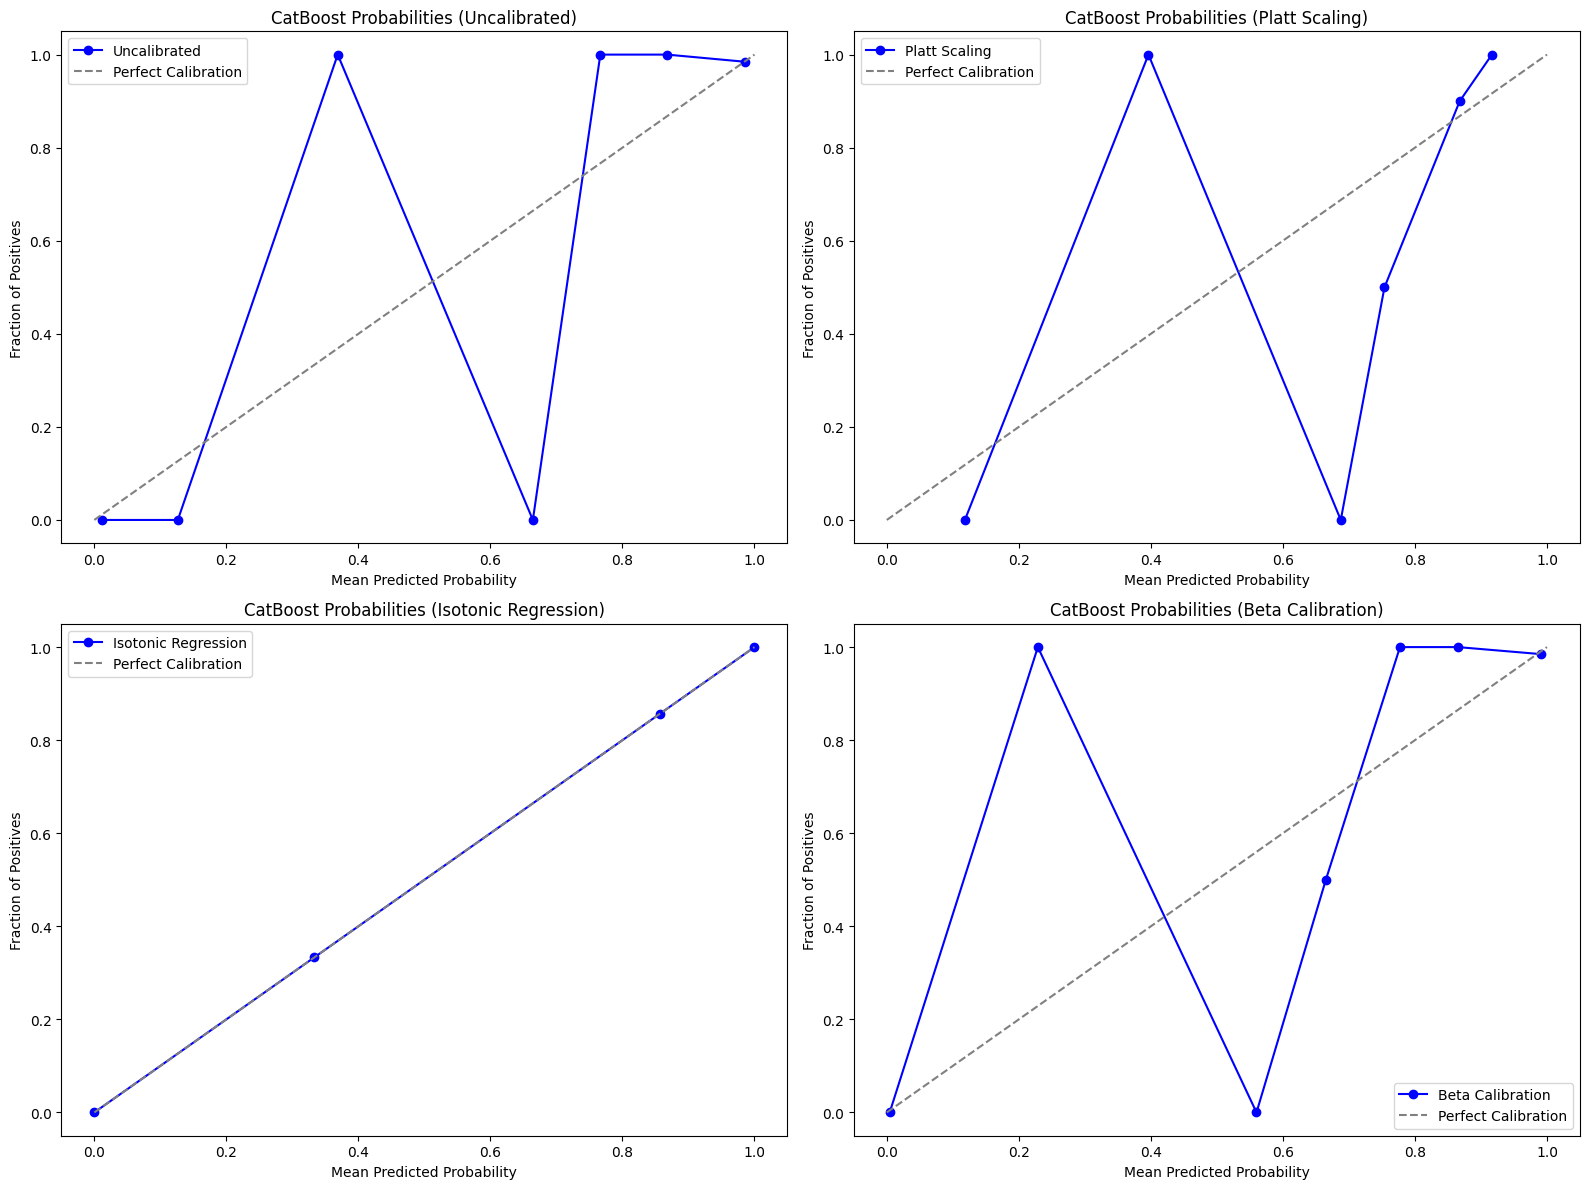

{'Uncalibrated': 0.033298917425189006,
 'Platt Scaling': 0.10401157385506696,
 'Isotonic Regression': 6.817158923136926e-18,
 'Beta Calibration': 0.026092171492882173}

In [10]:
# Импорт необходимых библиотек
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from betacal import BetaCalibration
from catboost import CatBoostClassifier
import numpy as np

# Загрузка небольшого датасета
data = load_breast_cancer()
X, y = data.data, data.target

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=50, depth=4, learning_rate=0.1, verbose=False)
catboost_model.fit(X_train, y_train)

# Получение вероятностей из коробки
probs_catboost = catboost_model.predict_proba(X_test)[:, 1]

# Platt Scaling
platt_model = LogisticRegression()
platt_model.fit(probs_catboost.reshape(-1, 1), y_test)
probs_platt = platt_model.predict_proba(probs_catboost.reshape(-1, 1))[:, 1]

# Isotonic Regression
iso_model = IsotonicRegression(out_of_bounds="clip")
iso_model.fit(probs_catboost, y_test)
probs_isotonic = iso_model.predict(probs_catboost)

# Beta Calibration
beta_calibrator = BetaCalibration()
beta_calibrator.fit(probs_catboost, y_test)
probs_beta = beta_calibrator.predict(probs_catboost)

# Вычисление ECE
def ece_score(y_true, y_probs, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_probs > bin_lower) & (y_probs <= bin_upper)
        prob_in_bin = y_probs[in_bin]
        if len(prob_in_bin) == 0:
            continue
        avg_pred = prob_in_bin.mean()
        avg_true = y_true[in_bin].mean()
        ece += np.abs(avg_pred - avg_true) * len(prob_in_bin) / len(y_true)
    return ece

ece_results = {
    "Uncalibrated": ece_score(y_test, probs_catboost),
    "Platt Scaling": ece_score(y_test, probs_platt),
    "Isotonic Regression": ece_score(y_test, probs_isotonic),
    "Beta Calibration": ece_score(y_test, probs_beta)
}

# Построение графиков вероятностей
plt.figure(figsize=(16, 12))

methods = {
    "Uncalibrated": probs_catboost,
    "Platt Scaling": probs_platt,
    "Isotonic Regression": probs_isotonic,
    "Beta Calibration": probs_beta,
}

for i, (method, probs) in enumerate(methods.items(), 1):
    plt.subplot(2, 2, i)
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=method, linestyle='-', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.title(f"CatBoost Probabilities ({method})")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()

plt.tight_layout()
plt.show()

ece_results


In [11]:
# Подготовка первых 10 вероятностей для каждого метода
results = {
    "Uncalibrated": probs_catboost[:10],
    "Platt Scaling": probs_platt[:10],
    "Isotonic Regression": probs_isotonic[:10],
    "Beta Calibration": probs_beta[:10],
}

# Преобразование в DataFrame для наглядности
import pandas as pd
probs_df = pd.DataFrame(results)

# Вывод результатов
probs_df

,Uncalibrated,Platt Scaling,Isotonic Regression,Beta Calibration
0,0.967861,0.908514,1.000000,0.983123
1,0.003544,0.111411,0.000000,0.000357
2,0.013479,0.115949,0.000000,0.002091
3,0.993406,0.917695,1.000000,0.998039
4,0.999013,0.919595,1.000000,0.999849
5,0.002101,0.110765,0.000000,0.000179
6,0.003262,0.111284,0.000000,0.000320
7,0.108199,0.167713,0.000000,0.035821
8,0.368725,0.396338,0.333333,0.228829
9,0.992012,0.917217,1.000000,0.997458


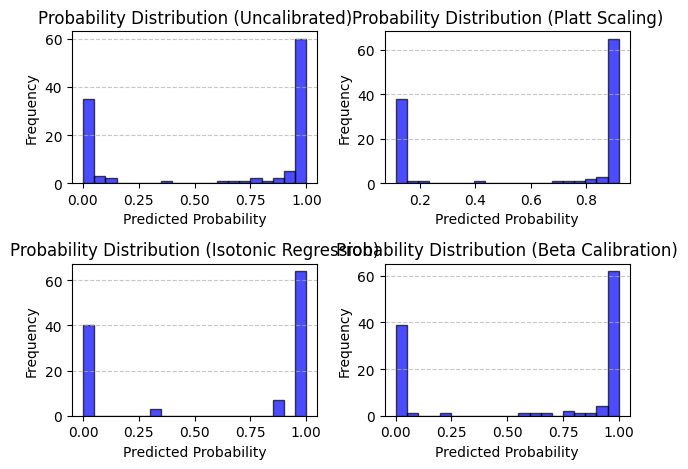

In [12]:
for i, (method, probs) in enumerate(methods.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(probs, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Probability Distribution ({method})")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()